<a href="https://colab.research.google.com/github/pjcroxas/Data-Analytics-Case-Studies/blob/main/CO2_Emission_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import describe
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression

In [2]:
# Read Dataset
dirs = "/content/drive/My Drive/Data Science Portfolio/CO2 Forecasting/CO2 Emission/data"

# Primary Dataset
train = pd.read_csv(dirs+"/train.csv")
test_target = pd.read_csv(dirs+"/test_target.csv") # With label
test = pd.read_csv(dirs+"/test.csv") # without label

# Secondary Datasets
gdp = pd.read_csv(dirs+"/gdp.csv")
population = pd.read_csv(dirs+"/population.csv")
vehicle_sales = pd.read_csv(dirs+"/vehicle_sales.csv")

# **Check Dataset**
**Primary data**

In [3]:
train.sample(3)

,year,month,source,fuel_type,emissions_tons
63,1992,4,transport,oil,2586.91
992,1999,9,other,oil,1110.79
1068,2006,1,other,oil,1382.67


In [4]:
test_target.sample(3)

,year,month,source,fuel_type,emissions_tons
35,2022,12,other,oil,1222.93
5,2022,6,transport,oil,6172.97
15,2022,4,industry,oil,1061.33


In [5]:
test.sample(3)

,year,month,source,fuel_type
55,2022,8,transport,natural_gas
47,2022,12,industry,coal
0,2022,1,transport,oil


**Secondary data**

The secondary data are essential in analyzing the dataset. We will need to join these (3) datasets to the training, test target, and test set, in order to find the relationship of this data.

In [6]:
gdp.sample(3)

,Year,Quarter,GDP_(current_mkt_value),GDP_(ref_year=2002)
104,2019,Q1,4223706.0,2850075.0
23,1998,Q4,1199041.0,1265055.0
76,2012,Q1,3046078.0,2272805.0


In [7]:
gdp.Quarter.value_counts()

Quarter
Q1    30
Q2    30
Q3    30
Q4    30
Name: count, dtype: int64

In [8]:
population.sample(3)

,Year,Population
16,2009,63525062
22,2015,65729098
5,1998,61466178


In [9]:
vehicle_sales.sample(3)

,year,passenger,commercial,motorcycle,total
2,1988,39232,107763,494586,641581
17,2003,179418,354037,1687000,2220455
1,1987,26909,74451,310579,411939


# **Data Processing**

In [10]:
def create_quarter(feature):
  if feature in (1, 2, 3):
    return "Q1"
  elif feature in (4, 5, 6):
    return "Q2"
  elif feature in (7, 8, 9):
    return "Q3"
  elif feature in (10, 11, 12):
    return "Q4"
  else:
    pass

train["Quarter"] = train["month"].apply(create_quarter)
test_target["Quarter"] = test_target["month"].apply(create_quarter)
test["Quarter"] = test["month"].apply(create_quarter)

In [11]:
def join_secondary_data(gdp, pop, sales, main):
  gdp = gdp.rename(columns=lambda x: x.lower())
  pop = pop.rename(columns=lambda x: x.lower())
  main = main.rename(columns=lambda x: x.lower())

  main_gdp = main.merge(gdp, on=["year", "quarter"])
  main_pop = main_gdp.merge(pop, on=["year"])
  main_sales = main_pop.merge(sales, on=["year"])

  return main_sales

# Join the datasets
co_train = join_secondary_data(gdp, population, vehicle_sales, train)
co_validation = join_secondary_data(gdp, population, vehicle_sales, test_target)
co_test = join_secondary_data(gdp, population, vehicle_sales, test)
co_train.sample(5)

,year,month,source,fuel_type,emissions_tons,quarter,gdp_(current_mkt_value),gdp_(ref_year=2002),population,passenger,commercial,motorcycle,total
252,1997,1,industry,natural_gas,177.71,Q1,1168694.0,1318993.0,60816227,132070,231198,927365,1290633
1177,2010,8,transport,natural_gas,325.82,Q3,2656614.0,1982245.0,63878267,340129,390904,1870000,2601033
554,2002,3,transport,oil,4260.35,Q1,1430285.0,1441030.0,62799872,126330,283073,1317000,1726403
850,2006,2,industry,coal,2235.68,Q1,2114526.0,1810063.0,62828706,191405,490603,1921000,2603008
743,2004,9,industry,coal,1757.11,Q3,1721028.0,1596306.0,61973621,209114,416764,1951000,2576878


# **EDA**

**I. Descriptive Statistics**

In [12]:
columns = ['emissions_tons','gdp_(current_mkt_value)', 'gdp_(ref_year=2002)', 'population',
       'passenger', 'commercial', 'motorcycle', 'total']
CO_numeric = co_train[columns]

In [13]:
CO_desc = CO_numeric.describe().T
CO_desc["skewness"] = CO_numeric.skew()
CO_desc["kurtosis"] = CO_numeric.kurt()
CO_desc

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
emissions_tons,1992.0,1.756151e+03,1.501124e+03,0.39,7.490325e+02,1271.82,2416.45,6816.78,1.153890,0.399354
gdp_(current_mkt_value),1992.0,2.414272e+06,1.094657e+06,782212.00,1.315906e+06,2348982.00,3407492.00,4336605.00,0.193575,-1.345070
gdp_(ref_year=2002),1992.0,1.893963e+06,5.193153e+05,1039924.00,1.352158e+06,1893689.00,2348899.00,2850075.00,0.104307,-1.268303
population,1992.0,6.336950e+07,2.232093e+06,58336072.00,6.197362e+07,63389730.00,65729098.00,66558935.00,-0.371457,-0.621131
passenger,1992.0,2.613479e+05,1.503748e+05,46399.00,1.587010e+05,225751.00,341800.00,658460.00,1.099208,0.934945
commercial,1992.0,3.918469e+05,1.322985e+05,97844.00,3.137030e+05,409349.00,461692.00,691399.00,-0.052260,0.102358
motorcycle,1992.0,1.531054e+06,4.267962e+05,490829.00,1.317000e+06,1635000.00,1859000.00,2300000.00,-0.681029,-0.022476
total,1992.0,2.184249e+06,6.682226e+05,635072.00,1.818886e+06,2297671.00,2603008.00,3649859.00,-0.333809,0.169594


1. `emission_tons` and `passenger` are both positively skewed, this means that the tail is longer on the right side of the mean, and most of the emission are low.
2. `gdp_(current_mkt_value)` and `gdp_(ref_year=2022)` are both 'slightly' positively skewed, this means that the tail of of distribution is also longer on the right of the mean. And most of the values are low.
3. `population` is obviously negatively skewed, this means that the tail is longer on the left side of the mean. Most of the values are very high.
4. `commercial`, `motorcycle`, and `total` are all negative skewed, this means that the tail is longer on the left side of the mean, and most of the values are concentrated on this right side and very high.

**II. Correlation**

<Axes: >

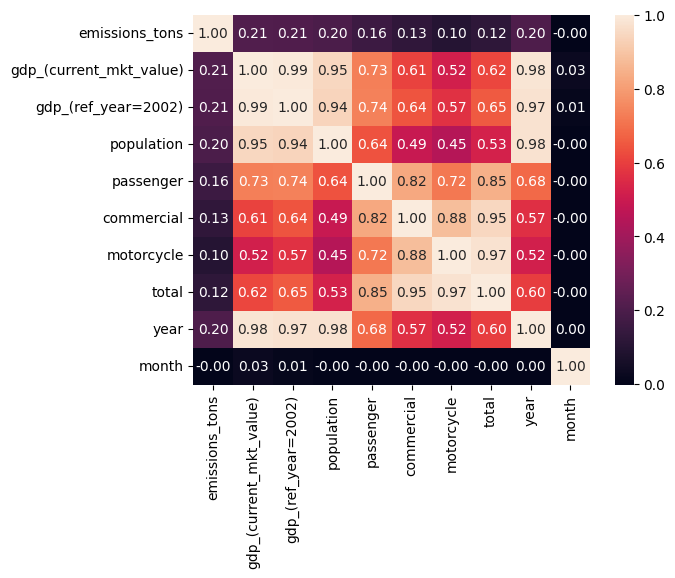

In [53]:
columns = ['emissions_tons','gdp_(current_mkt_value)', 'gdp_(ref_year=2002)', 'population',
       'passenger', 'commercial', 'motorcycle', 'total', 'year', 'month']
CO_numeric = co_train[columns]
CO_valid_numeric = co_validation[columns]
CO_test_numeric = co_test[['gdp_(current_mkt_value)', 'gdp_(ref_year=2002)',
                          'population','passenger', 'commercial', 'motorcycle',
                          'total', 'year', 'month']]
sns.heatmap(CO_numeric.corr(),
            annot=True,
            fmt=".2f")

1. `emission_tons` has slightly positive correlation against the independent variables. (corr~ 0.12-0.21).
2. independent variables has strong positive correlation against each other (corr~ 0.52-1.00). This may pose a problem of `Autocorrelation`.


**III. Statistical Significance**

In [15]:
# Ordinary Least Square Method
def OLS(target_variable, data):
  Y = data[target_variable]
  X = data.drop([target_variable], axis=1)
  X = sm.add_constant(X)
  model = sm.OLS(Y, X)
  results = model.fit()
  return results

In [16]:
results = OLS("emissions_tons", CO_numeric)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         emissions_tons   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     11.79
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.58e-16
Time:                        06:45:56   Log-Likelihood:                -17349.
No. Observations:                1992   AIC:                         3.472e+04
Df Residuals:                    1983   BIC:                         3.477e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6

1. The model has very weak explanatory power, with `r-squared` of 0.045 and `adj r-squared` of 0.042 only.
2. ALL variables are not statistically significant.

**IV. Mutual Information Score**

In [17]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(figsize=(15, 5))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

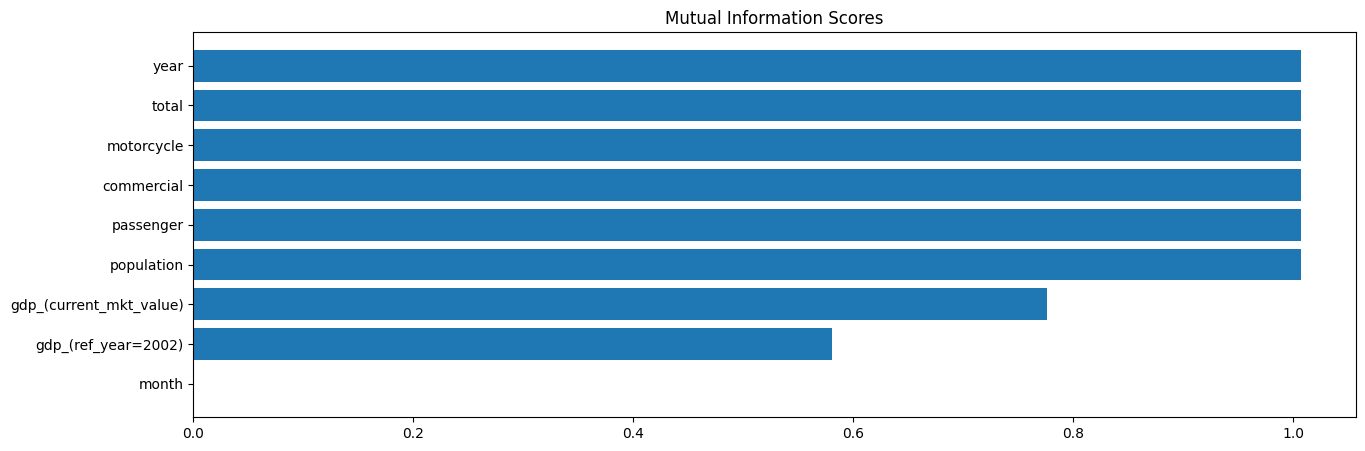

In [18]:
Y = CO_numeric["emissions_tons"]
X = CO_numeric.drop("emissions_tons", axis=1)
mi_scores = make_mi_scores(X, Y)
plot_mi_scores(mi_scores)

# **Data Visualization**

In [19]:
co_train_da = co_train.copy()
co_train_da["year_"] = co_train_da["year"].astype(str)
emission_grp_year = co_train_da.groupby(["year", "month"]).sum()["emissions_tons"].reset_index()

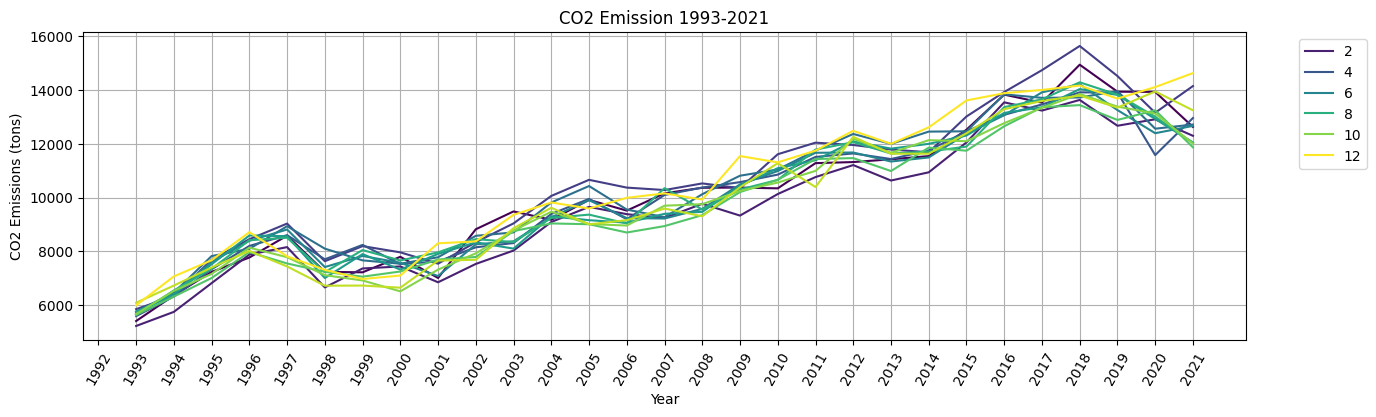

In [20]:
plt.figure(figsize=(15, 4))
ax = sns.lineplot(emission_grp_year,
             x="year",
             y="emissions_tons",
             hue="month",
             palette="viridis")

plt.title("CO2 Emission 1993-2021")
plt.legend(bbox_to_anchor=(1.04, 1), loc=2)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (tons)")
ax.xaxis.set_ticks(np.arange(1992, 2022, 1))
plt.xticks(rotation=60)
plt.grid()

<ipython-input-21-e9e32893eb28>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(emission_grp_year,


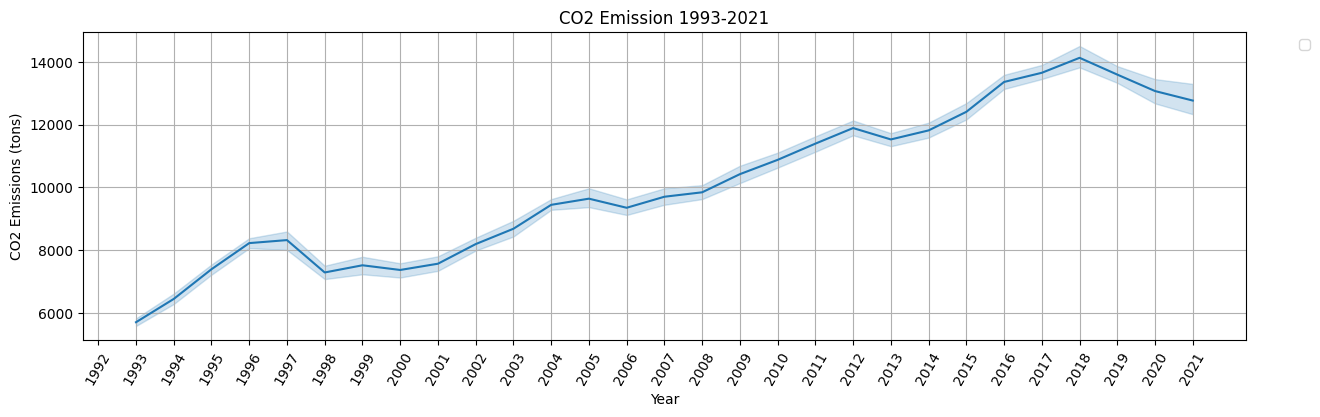

In [21]:
plt.figure(figsize=(15, 4))
ax = sns.lineplot(emission_grp_year,
             x="year",
             y="emissions_tons",
            #  hue="month",
             palette="viridis")

plt.title("CO2 Emission 1993-2021")
plt.legend(bbox_to_anchor=(1.04, 1), loc=2)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (tons)")
ax.xaxis.set_ticks(np.arange(1992, 2022, 1))
plt.xticks(rotation=60)
plt.grid()

1. CO2 follows an increasing linear trend from 1992 from 2021.
2. CO2 Emission has 4 peaks from 1992 to 2021. Those year are `1997`, `2005`, `2012`, and `2017`.
3. CO2 Emission has 4 through, these are year `1998`, `2006`, `2013`, and `2021`.


<ipython-input-22-5b4be455cd63>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(emission_grp_passenger,


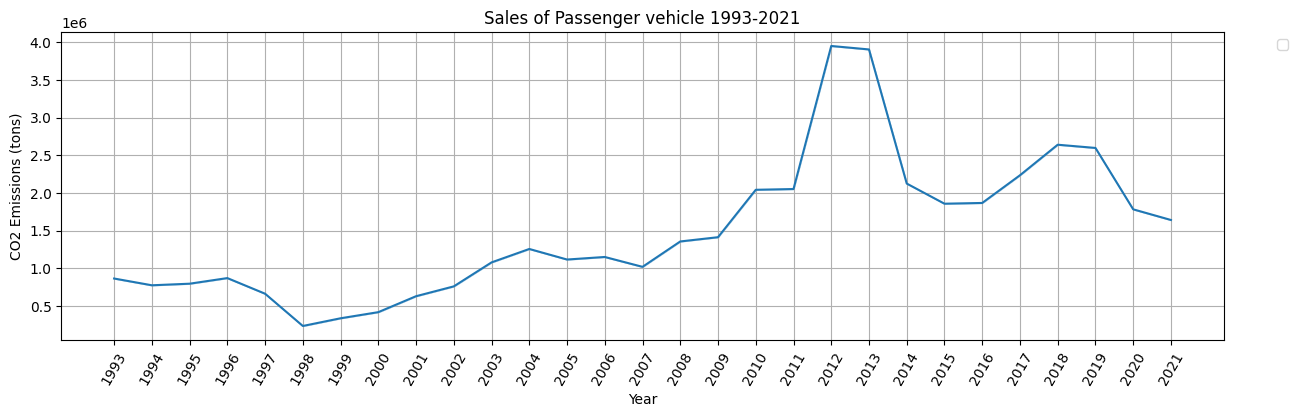

In [22]:
emission_grp_passenger = co_train_da.groupby(["year", "month"]).sum()["passenger"].reset_index()
plt.figure(figsize=(15, 4))
ax = sns.lineplot(emission_grp_passenger,
             x="year",
             y="passenger",
            #  hue="month",
             palette="viridis")
plt.title("Sales of Passenger vehicle 1993-2021")
plt.legend(bbox_to_anchor=(1.04, 1), loc=2)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (tons)")
ax.set_xticks(np.arange(1993, 2022))
plt.xticks(rotation=60)
plt.grid()

<ipython-input-23-00172b58aefc>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(emission_grp_passenger,


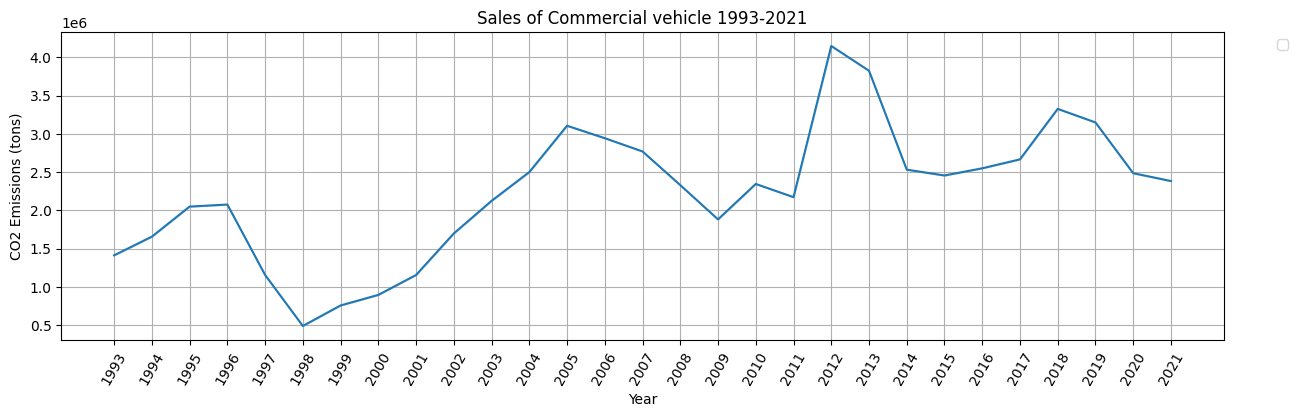

In [23]:
emission_grp_passenger = co_train_da.groupby(["year", "month"]).sum()["commercial"].reset_index()
plt.figure(figsize=(15, 4))
ax = sns.lineplot(emission_grp_passenger,
             x="year",
             y="commercial",
            #  hue="month",
             palette="viridis")
plt.title("Sales of Commercial vehicle 1993-2021")
plt.legend(bbox_to_anchor=(1.04, 1), loc=2)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (tons)")
ax.set_xticks(np.arange(1993, 2022))
plt.xticks(rotation=60)
plt.grid()

<ipython-input-24-0836fe9f9fdb>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(emission_grp_motorcycle,


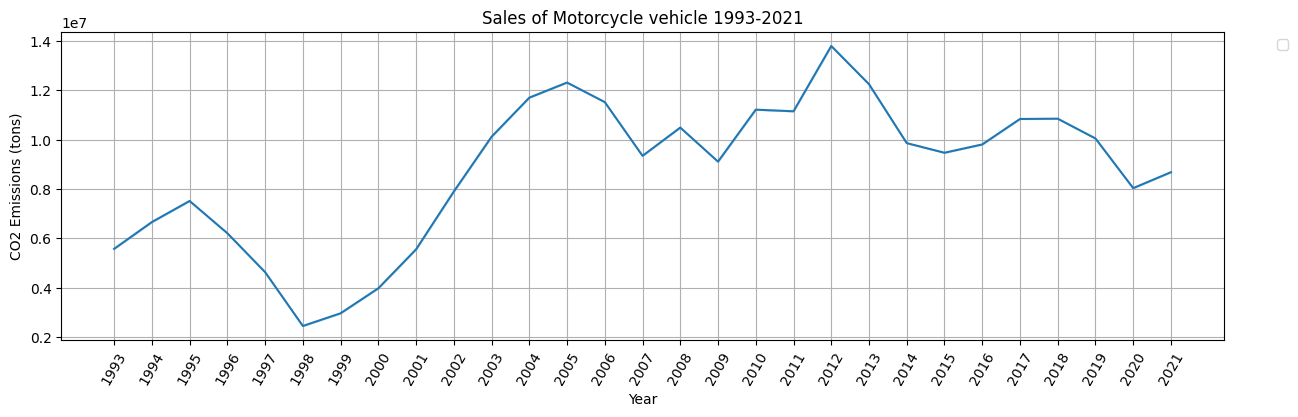

In [24]:
emission_grp_motorcycle = co_train_da.groupby(["year", "month"]).sum()["motorcycle"].reset_index()
plt.figure(figsize=(15, 4))
ax = sns.lineplot(emission_grp_motorcycle,
             x="year",
             y="motorcycle",
            #  hue="month",
             palette="viridis")
plt.title("Sales of Motorcycle vehicle 1993-2021")
plt.legend(bbox_to_anchor=(1.04, 1), loc=2)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (tons)")
ax.set_xticks(np.arange(1993, 2022))
plt.xticks(rotation=60)
plt.grid()

# **Modeling: Linear Regression**

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error as mse,
                             r2_score as r2,
                             mean_absolute_error as mae)

**I. Encoding Categorical Data**

In [31]:
CO_numeric.sample(3)

,emissions_tons,gdp_(current_mkt_value),gdp_(ref_year=2002),population,passenger,commercial,motorcycle,total,year,month
1979,1139.22,4295500.0,2732051.0,66171439,273272,397229,1447569,2118070,2021,12
1636,1421.10,3830606.0,2638918.0,66188503,372278,444435,1807000,2623713,2017,2
1595,1708.80,3557050.0,2390876.0,65931550,310974,424980,1635000,2370954,2016,6


In [46]:
new_copy = co_train.copy()
new_df = pd.get_dummies(new_copy["source"])

def encode_cat_types(data):
  enc_source = pd.get_dummies(data["source"])
  enc_fuel_type = pd.get_dummies(data["fuel_type"])
  enc_quarter = pd.get_dummies(data["quarter"])
  enc_cat = pd.concat([enc_source, enc_fuel_type, enc_quarter], axis=1)

  return enc_cat

In [55]:
# Encode Categorical data
enc_train = encode_cat_types(co_train)
enc_valid = encode_cat_types(co_validation)
enc_test = encode_cat_types(co_test)

# Join with numeric data
main_train = pd.concat([CO_numeric, enc_cat], axis=1)
main_valid = pd.concat([CO_valid_numeric, enc_valid], axis=1)
main_test = pd.concat([CO_test_numeric, enc_test], axis=1)

In [60]:
linreg_model = LinearRegression()
y_train = main_train["emissions_tons"]
X_train = main_train.drop(["emissions_tons"], axis=1)

y_valid = main_valid["emissions_tons"]
X_valid = main_valid.drop(["emissions_tons"], axis=1)

linreg_model.fit(X_train, y_train)

LinearRegression()

In [73]:
# Prediction
pred_emissions = linreg_model.predict(X_valid)
print("R2: ", r2(y_valid, pred_emissions))
print("MSE: ", mse(y_valid, pred_emissions))
print("RMSE: ", np.sqrt(mse(y_valid, pred_emissions)))
print("MAE: ", mae(y_valid, pred_emissions))

R2:  0.4829881439562298
MSE:  2156910.8512733467
RMSE:  1468.6425199051494
MAE:  1277.2540337422308


Text(0.5, 0, 'Distribution of error between predicted and actual emissions')

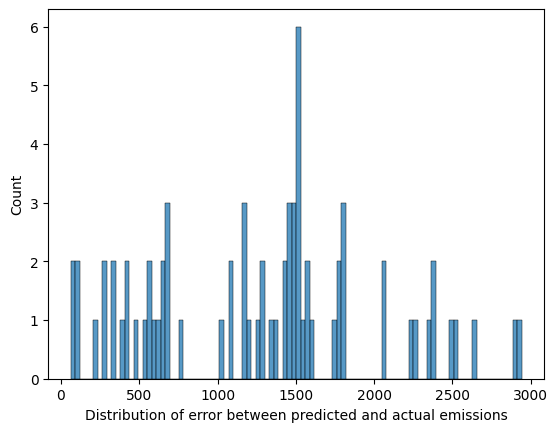

In [75]:
error = np.abs(y_valid-pred_emissions)
sns.histplot(error, bins=100)
plt.xlabel("Distribution of error between predicted and actual emissions")

Text(37.722222222222214, 0.5, 'Actual Emission')

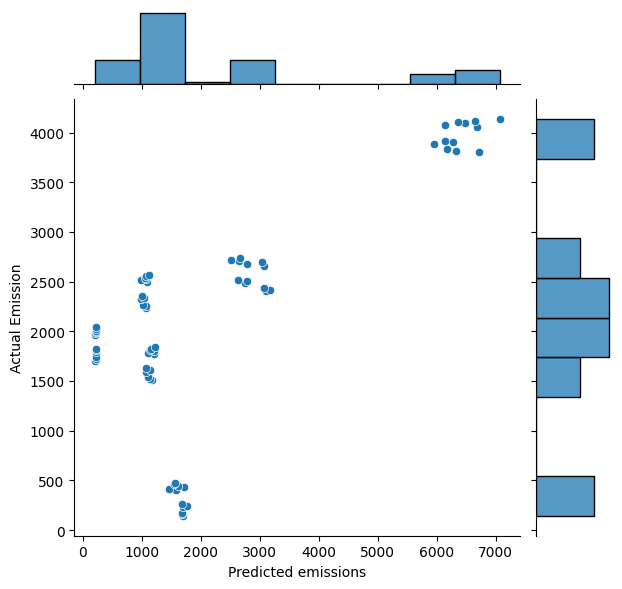

In [74]:
sns.jointplot(x=y_valid, y=pred_emissions)
plt.xlabel("Predicted emissions")
plt.ylabel("Actual Emission")